In [583]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [584]:
print('Numpy', np.__version__)
print('Pandas', pd.__version__)

Numpy 1.19.5
Pandas 1.1.5


# Case for Gorilla.co
### Exploratory Data Analysis

### Load Datasets

In [585]:
xlsx = pd.ExcelFile('data.xlsx', engine='openpyxl')
xlsx.sheet_names

['Forecasted Consumption', 'Meter List', 'Rates']

There are three sheets. Lets load them individually into a DataFrame

In [586]:
df_forecasted_consumption = pd.read_excel(xlsx, 'Forecasted Consumption')
df_meter_list = pd.read_excel(xlsx, 'Meter List')
df_rates = pd.read_excel(xlsx, 'Rates')

## Explore

In [587]:
df_forecasted_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2190 non-null   datetime64[ns]
 1   Meter ID  2190 non-null   int64         
 2   kWh       2190 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 51.5 KB


In [588]:
df_meter_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Meter ID               3 non-null      int64 
 1   Exit Zone              3 non-null      object
 2   Annual Quantity (kWh)  3 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes


In [589]:
df_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1026 non-null   datetime64[ns]
 1   Exit Zone              1026 non-null   object        
 2   Annual Quantity (Min)  1026 non-null   int64         
 3   Annual Quantity (Max)  684 non-null    float64       
 4   Rate (p/kWh)           1026 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 40.2+ KB


First things we notice is
* Rate (p/kWh) is stored as a float64
* kWh have different types (float64 vs int64) in each dataframe, we might need to take care of this.
    * Annual Quantity Min/Max have different dtypes. *What are these numbers anyway?*
* Annual Quantity (Max) is the only value with null types. *why?*

Note, a float64 is an approximation and therefore takes less memory space, but int64 is more accurate with arithmetic operations. 

#### Forecasted Consumption

In [590]:
df_forecasted_consumption

Date    Meter ID         kWh
0    2020-10-01  1000000603   28.782474
1    2020-10-01    10588707  126.367711
2    2020-10-01    10626610  326.240595
3    2020-10-02  1000000603   26.690797
4    2020-10-02    10588707  118.322449
...         ...         ...         ...
2185 2022-09-29    10588707   77.744203
2186 2022-09-29    10626610  270.357196
2187 2022-09-30  1000000603   17.927143
2188 2022-09-30    10588707   73.335098
2189 2022-09-30    10626610  263.375674

[2190 rows x 3 columns]

It seems that df_forecasted_consumption contains the daily (forcasted) use of kWh's for each Meter.

* First date is 2020-10-01
* Last date is 2022-09-30

Seems like two years of forecastes. 2190 records / 3 = 730 / 365 = 2. Check

In [591]:
desc = df_forecasted_consumption.groupby('Meter ID')['kWh'].describe()
desc

count        mean         std         min         25%         50%  \
Meter ID                                                                        
10588707    730.0  167.739726  104.619187   31.559540   57.876465  166.368491   
10626610    730.0  415.832877  191.285061  155.716560  216.566218  407.146619   
1000000603  730.0   33.800000   18.311935    8.024519   14.436455   34.685790   

                   75%         max  
Meter ID                            
10588707    258.402884  344.678606  
10626610    586.364091  735.103232  
1000000603   49.045715   64.713218

Ranking (Meter ID)
1. 10626610
1. 10588707
1. 1000000603

10588707           AxesSubplot(0.1,0.15;0.235294x0.75)
10626610      AxesSubplot(0.382353,0.15;0.235294x0.75)
1000000603    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

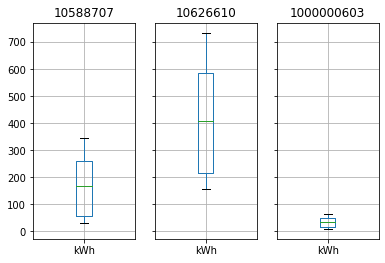

In [592]:
df_forecasted_consumption.groupby('Meter ID').boxplot(column=['kWh'], layout=(1,3))

In [593]:
df_line = df_forecasted_consumption.set_index('Date').groupby('Meter ID')['kWh']

Meter ID
10588707      AxesSubplot(0.125,0.125;0.775x0.755)
10626610      AxesSubplot(0.125,0.125;0.775x0.755)
1000000603    AxesSubplot(0.125,0.125;0.775x0.755)
Name: kWh, dtype: object

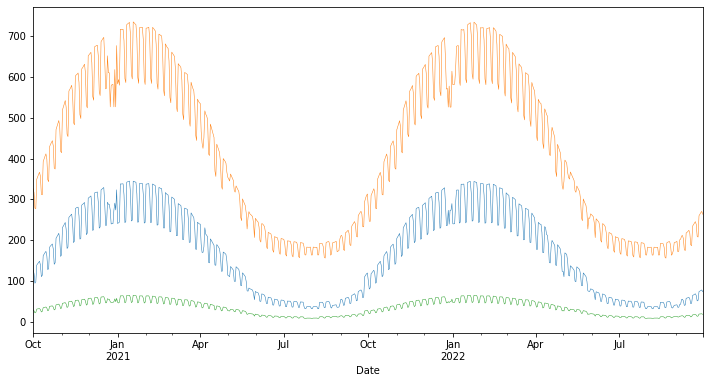

In [594]:
df_line.plot(linewidth=0.5, figsize=(12,6))

Note that we only have two years to analyse but it seems that we have seasonal changes and a trend during the colder month -> more kWh is used. 

Lets dive deeper into this... 

In [595]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [596]:
df_forecasted_consumption = df_forecasted_consumption.set_index('Date')

Analysing Meter ID 10626610

In [597]:
from statsmodels.graphics.tsaplots import plot_acf

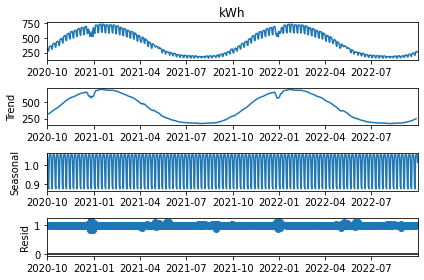

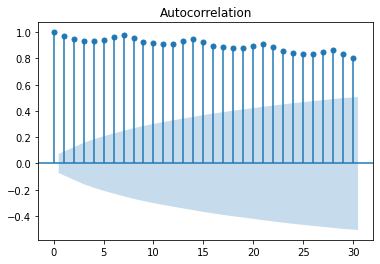

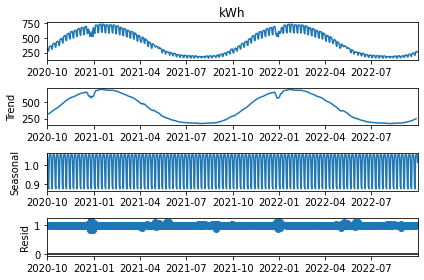

In [598]:
analysis_106 = df_forecasted_consumption.loc[(df_forecasted_consumption['Meter ID'] == 10626610)]['kWh'].copy()

plot_acf(analysis_106, lags=30)

decompose_result_mult_106 = seasonal_decompose(analysis_106, model="multiplicative")
# 75123

trend_106 = decompose_result_mult_106.trend
seasonal_106 = decompose_result_mult_106.seasonal
residual_106 = decompose_result_mult_106.resid

decompose_result_mult_106.plot()

Analysing Meter ID 10588707

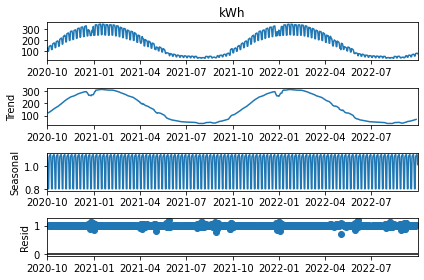

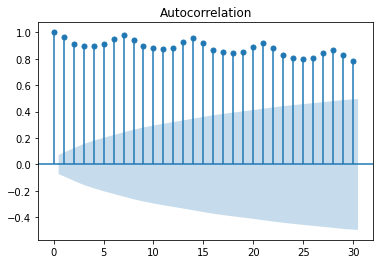

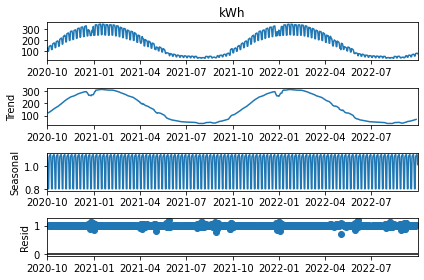

In [599]:
analysis_105 = df_forecasted_consumption.loc[(df_forecasted_consumption['Meter ID'] == 10588707)]['kWh'].copy()

plot_acf(analysis_105, lags=30)

decompose_result_mult_105 = seasonal_decompose(analysis_105, model="multiplicative")

trend_105 = decompose_result_mult_105.trend
seasonal_105 = decompose_result_mult_105.seasonal
residual_105 = decompose_result_mult_105.resid

decompose_result_mult_105.plot()

Analysing Meter ID 1000000603

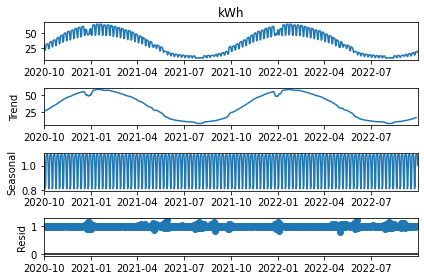

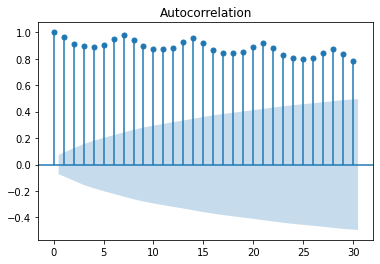

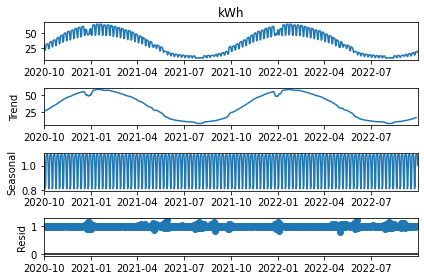

In [600]:
analysis_100 = df_forecasted_consumption.loc[(df_forecasted_consumption['Meter ID'] == 1000000603)]['kWh'].copy()

plot_acf(analysis_100, lags=30)

decompose_result_mult_100 = seasonal_decompose(analysis_100, model="multiplicative")

trend_100 = decompose_result_mult_100.trend
seasonal_100 = decompose_result_mult_100.seasonal
residual_100 = decompose_result_mult_100.resid

decompose_result_mult_100.plot()

<AxesSubplot:xlabel='Date'>

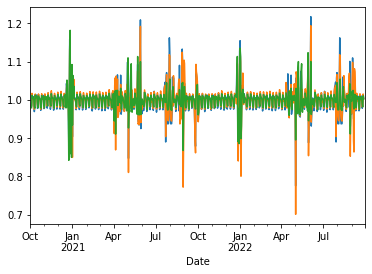

In [601]:
residual_100.plot()
residual_105.plot()
residual_106.plot()

Lets asses the trend and see if we can find a fitting model.

<AxesSubplot:xlabel='Date'>

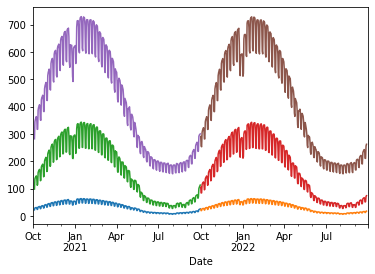

In [602]:
y_100 = trend_100 * seasonal_100 #* residual_100
y_105 = trend_105 * seasonal_105 #* residual_105
y_106 = trend_106 * seasonal_106 #* residual_106

y_100[:365].plot()
y_100[365:].plot()

y_105[:365].plot()
y_105[365:].plot()

y_106[:365].plot()
y_106[365:].plot()

<AxesSubplot:xlabel='Date'>

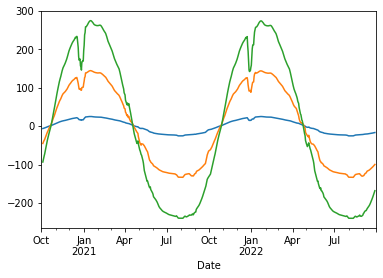

In [603]:
a = trend_100 - np.mean(trend_100) # 30
b = trend_105 - np.mean(trend_105) # 120
c = trend_106 - np.mean(trend_106) # 415 - 155'000

a.plot()
b.plot()
c.plot()

# f(y|mean) = A(mean) * sin(time)


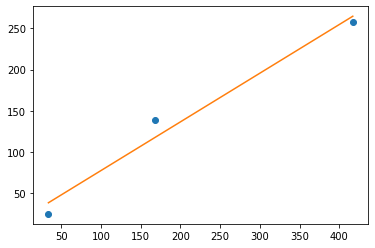

In [638]:
a_100 = (np.max(trend_100) - np.min(trend_100)) / 2
a_105 = (np.max(trend_105) - np.min(trend_105)) / 2
a_106 = (np.max(trend_106) - np.min(trend_106)) / 2
A_trend_100 = a_100
A_trend_105 = a_105
A_trend_106 = a_106

# x = np.array([np.mean(trend_100), np.mean(trend_105), np.mean(trend_106)])
x = np.array([np.mean(trend_100), np.mean(trend_105), np.mean(trend_106)])
y = np.array([A_trend_100, A_trend_105, A_trend_106])

m_trend, b_trend = np.polyfit(x,y, 1)
plt.plot(x,y,'o')
plt.plot(x,m_trend*x+b_trend)

def getAmplitudeTrend(mean):
    '''Return the amplitude based on the linear regression from training data'''
    return m_trend * mean + b_trend
    

Too little data but might be linear. Let see..

In [605]:
def mock_trend(mean):
    x = np.arange(0,730,1)
    # y = A sin(Bx + horizontalShift) + verticalShift
    A = getAmplitudeTrend(mean)
    B = 2*np.pi / 365
    v_shift = mean # up down
    h_shift = -0.4 # left right

    y = A * np.sin(B*x + h_shift) + v_shift
    return y

In [606]:
mock_trend_100 = mock_trend(np.mean(trend_100))
mock_trend_105 = mock_trend(np.mean(trend_105))
mock_trend_106 = mock_trend(np.mean(trend_106))

lines = pd.DataFrame([
    mock_trend_100, 
    mock_trend_105,
    mock_trend_106,  
    trend_100,
    trend_105,
    trend_106,
]).T
lines.columns = ['Mock Trend_100', 'Mock Trend_105', 'Mock Trend_106', 'Actual Trend_100', 'Actual Trend_105', 'Actual Trend_106']
px.line(lines)

Visually this seems a good fit. Amplitude seems not correct. Lower AQ(kWH) the Amplitude seems to high.

We could check later with MSE or other loss functions.

### Seasonal

<AxesSubplot:xlabel='Date'>

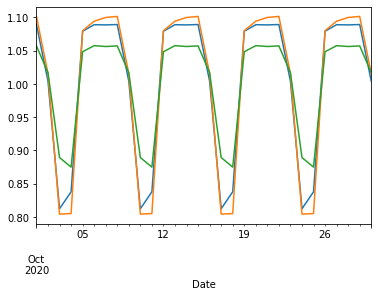

In [607]:
days = 30
a = seasonal_100[:days] #- np.mean(seasonal_100[:days])
b = seasonal_105[:days] #- np.mean(seasonal_105[:days])
c = seasonal_106[:days] #- np.mean(seasonal_106[:days])

a.plot()
b.plot()
c.plot()

# f(y|mean) = A(mean) * sin(time)

Seems like this will not be a linear fit

[1.00010122 1.00012773 1.00015992] [0.09127691 0.13846142 0.14854426]


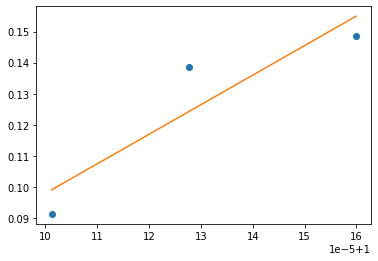

In [608]:
A_seasonal_100 = (np.max(seasonal_100) - np.min(seasonal_100)) / 2
A_seasonal_105 = (np.max(seasonal_105) - np.min(seasonal_105)) / 2
A_seasonal_106 = (np.max(seasonal_106) - np.min(seasonal_106)) / 2

x = np.array([np.mean(seasonal_106), np.mean(seasonal_100), np.mean(seasonal_105)])
y = np.array([A_seasonal_106,A_seasonal_100,A_seasonal_105])
print(x,y)
m_seasonal, b_seasonal = np.polyfit(x,y, deg=1)
plt.plot(x,y,'o')
plt.plot(x,m_seasonal*x+b_seasonal)
# plt.plot(x,y, '--')

def getAmplitudeSeasonal(mean):
    '''Return the amplitude based on the linear regression from training data'''
    return m_seasonal * mean + b_seasonal

Too little data to be sure this is correct. Might not be linear (?)

In [609]:
def mock_seasonal(mean):
    x = np.arange(0,730,1)
    # y = A sin(Bx + horizontalShift) + verticalShift
    A = getAmplitudeSeasonal(mean)
    B = 2*np.pi / 7
    v_shift = mean - 0.05 # up down
    h_shift = -0.4 # left right

    y = - A * np.sin(B*x + h_shift) + v_shift
    return y

In [610]:
days = 30
mock_seasonal_100 = mock_seasonal(np.mean(seasonal_100))
mock_seasonal_105 = mock_seasonal(np.mean(seasonal_105))
mock_seasonal_106 = mock_seasonal(np.mean(seasonal_106))

lines = pd.DataFrame([
    mock_seasonal_100[:days], 
    mock_seasonal_105[:days],
    mock_seasonal_106[:days],  
    seasonal_100[:days],
    seasonal_105[:days],
    seasonal_106[:days]
]).T
lines.columns = ['Mock seasonal_100', 'Mock seasonal_105', 'Mock seasonal_106', 'Actual seasonal_100', 'Actual seasonal_105', 'Actual seasonal_106']
px.line(lines)

<AxesSubplot:>

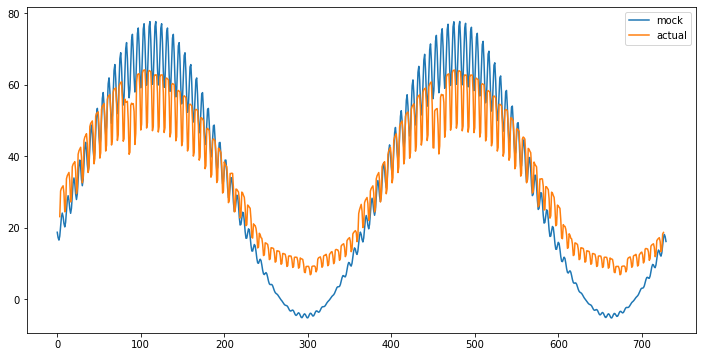

In [611]:
y_mock_100 = mock_trend_100 * mock_seasonal_100
y_100 = trend_100 * seasonal_100

df_lines = pd.DataFrame([y_mock_100, y_100]).T
df_lines.columns = ['mock', 'actual']
df_lines.plot(figsize=(12,6))

<AxesSubplot:>

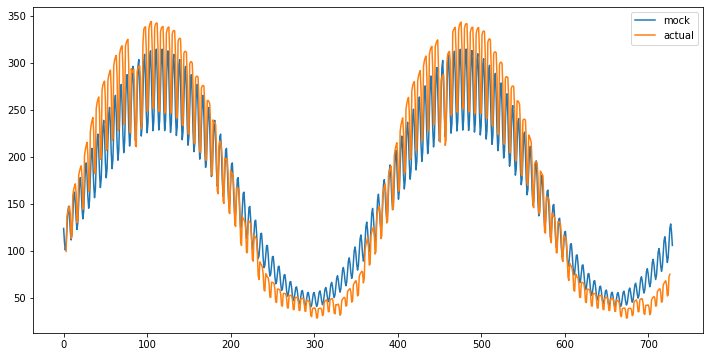

In [612]:
y_mock_105 = mock_trend_105 * mock_seasonal_105
y_105 = trend_105 * seasonal_105

df_lines = pd.DataFrame([y_mock_105, y_105]).T
df_lines.columns = ['mock', 'actual']
df_lines.plot(figsize=(12,6))

<AxesSubplot:>

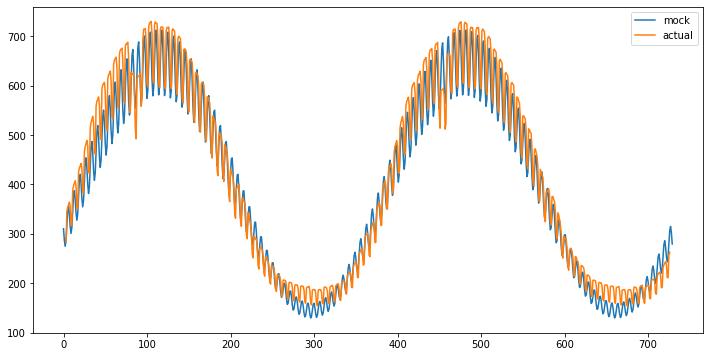

In [613]:
y_mock_106 = mock_trend_106 * mock_seasonal_106
y_106 = trend_106 * seasonal_106

df_lines = pd.DataFrame([y_mock_106, y_106]).T
df_lines.columns = ['mock', 'actual']
df_lines.plot(figsize=(12,6))

Looking at the three fits it seems that the function 'getAmplitudeTrend' we created is not linear. Need to look into this.

[416.89952761  33.89450147 168.34088665] [1.00010122 1.00012773 1.00015992]


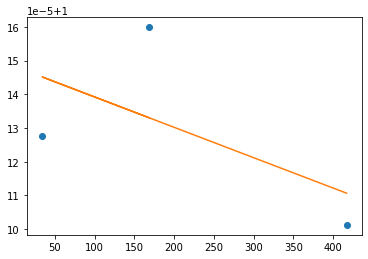

In [614]:
x = np.array([np.mean(trend_106), np.mean(trend_100), np.mean(trend_105)])
y = np.array([np.mean(seasonal_106), np.mean(seasonal_100), np.mean(seasonal_105)])

print(x, y)

m, b = np.polyfit(x,y, 1)
plt.plot(x,y,'o')
plt.plot(x,m*x+b)

def convertMeanTrendToMeanSeason(mean_trend):
    '''Return the amplitude based on the linear regression from training data'''
    return (m * mean_trend + b)

Useless idea !?

In [615]:
def mock_data(mean):
    t = mock_trend(mean)
    mean_s = convertMeanTrendToMeanSeason(mean)
    s = mock_seasonal(mean_s)
    return t * s

Hence, we have our first gready model.

<AxesSubplot:>

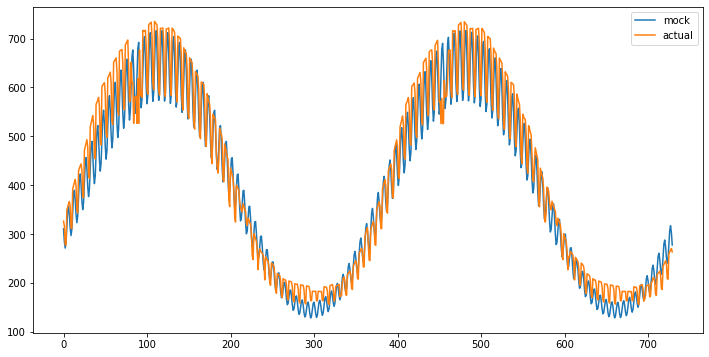

In [616]:
test_data = analysis_106
o_106 = mock_data(np.mean(test_data))

df_lines = pd.DataFrame([o_106, test_data]).T
df_lines.columns = ['mock', 'actual']
df_lines.plot(figsize=(12,6))

SCIPY approach

In [639]:
from scipy.optimize import curve_fit
# y = A sin(Bx + horizontalShift) + verticalShift
def sin(x,A, B, h_shift, v_shift):
 return A*np.sin(B*x+h_shift) + v_shift

T = 730

def get_p0(x, y):
 A0 = ( np.max( y[0:T] ) - np.min( y[0:T]) )/ 2
 v_shift0 = y[0]
 h_shift0 = 0
 B0 = 2.*np.pi/T
 return [A0, B0, h_shift0, v_shift0]

In [640]:
data_t_100 = trend_100[:T].fillna(0)
data_t_105 = trend_105[:T].fillna(0)
data_t_106 = trend_106[:T].fillna(0)
skip = 3 # skip the first three entries

In [642]:

X = np.arange(0,T-skip,1)
y_100 = data_t_100[skip:]
y_105 = data_t_105[skip:]
y_106 = data_t_106[skip:]
param_100, covariance = curve_fit(sin, X, y_100, p0=get_p0(X,y_100), maxfev=10000)
param_105, covariance = curve_fit(sin, X, y_105, p0=get_p0(X,y_105), maxfev=10000)
param_106, covariance = curve_fit(sin, X, y_106, p0=get_p0(X,y_106), maxfev=10000)

# A, B, h_shift, v_shift
print('A \t', param_100[0], param_105[0], param_106[0])
print('B \t', param_100[1], param_105[1], param_106[1])
print('h_shift', param_100[2], param_105[2], param_106[2])
print('v_shift', param_100[3], param_105[3], param_106[3])

A 	 24.79150686840983 141.44385457261103 -262.31281887399734
B 	 0.01680476961626353 0.01683049421887012 0.016843745669376634
h_shift -0.2117332301391207 -0.20503590645409595 -3.359297440232385
v_shift 33.48339285121069 166.23951170295655 412.5978205157554


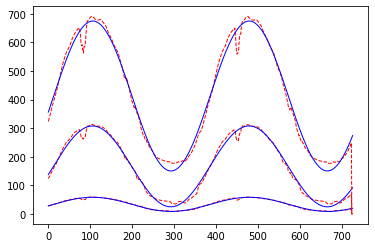

In [643]:
for y, param in [(y_100, param_100), (y_105, param_105), (y_106, param_106)]:
    plt.plot(X, y, color='red', linewidth=1,linestyle='dashed')
    plt.plot(X, sin(X, *param), color='blue', linewidth=1)

plt.show()

These fit much better but I expect the same problem with the Amplitude as before. We need more data in order to see if its a linear function or not. 

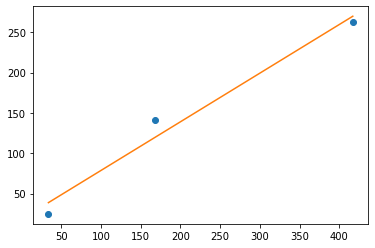

In [644]:
# x = np.array([np.mean(trend_100), np.mean(trend_105), np.mean(trend_106)])
x = np.array([np.mean(trend_100), np.mean(trend_105), np.mean(trend_106)])
y = np.array([param_100[0], param_105[0], -1*param_106[0]])

m_trend, b_trend = np.polyfit(x,y, 1)
plt.plot(x,y,'o')
plt.plot(x,m_trend*x+b_trend)

def getAmplitudeTrend_v2(mean):
    '''Return the amplitude based on the linear regression from training data'''
    return m_trend * mean + b_trend

In [645]:
def mock_trend_v2(mean):
    x = np.arange(0,730,1)
    # y = A sin(Bx + horizontalShift) + verticalShift
    A = getAmplitudeTrend_v2(mean)
    B = 2*np.pi / 365
    v_shift = mean # up down
    h_shift = -0.4 # left right

    y = A * np.sin(B*x + h_shift) + v_shift
    return y

<AxesSubplot:>

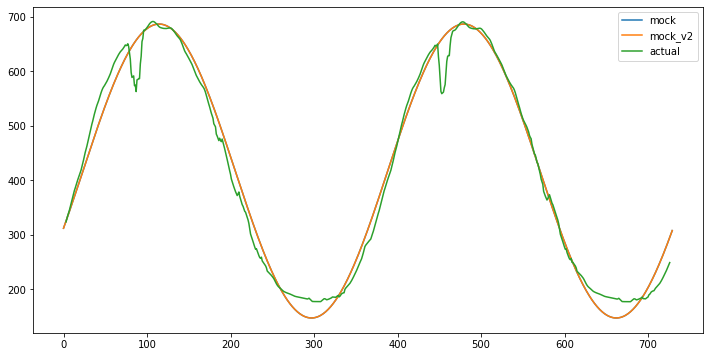

In [646]:
test_data = trend_106
o_106_v2 = mock_trend_v2(np.mean(test_data))
o_106 = mock_trend(np.mean(test_data))

df_lines = pd.DataFrame([o_106, o_106_v2, test_data]).T
df_lines.columns = ['mock', 'mock_v2', 'actual']
df_lines.plot(figsize=(12,6))

<AxesSubplot:>

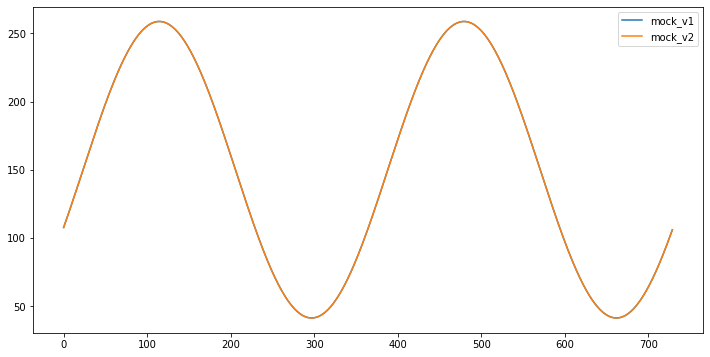

In [647]:
v2 = mock_trend_v2(150)
v1 = mock_trend(150)

df_lines = pd.DataFrame([v1, v2]).T
df_lines.columns = ['mock_v1', 'mock_v2']
df_lines.plot(figsize=(12,6))

#### Meter List

In [ ]:
df_meter_list

Meter ID Exit Zone  Annual Quantity (kWh)
0  1000000603       SC1                  12337
1    10588707       EM2                  75123
2    10626610       NW1                 151779

Meter ID with its corresponding Exit Zone. 

Not sure what the Annual Quantity (kWh) indicates right now. Past year or forecast? I cannot tell right now.

#### Rates

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
df_rates

Date Exit Zone  Annual Quantity (Min)  Annual Quantity (Max)  \
0    2020-04-01       EA1                      0                73200.0   
1    2020-04-01       EA2                      0                73200.0   
2    2020-04-01       EA3                      0                73200.0   
3    2020-04-01       EA4                      0                73200.0   
4    2020-04-01       EM1                      0                73200.0   
...         ...       ...                    ...                    ...   
1021 2024-04-01       WA1                 732000                    NaN   
1022 2024-04-01       WA2                 732000                    NaN   
1023 2024-04-01       WM1                 732000                    NaN   
1024 2024-04-01       WM2                 732000                    NaN   
1025 2024-04-01       WM3                 732000                    NaN   

      Rate (p/kWh)  
0         0.028700  
1         0.028700  
2         0.028700  
3         0.028700  
4         0.028700  
...            ...  
1021      0.384755  
1022      0.384755  
1023      0.445482  
1024      0.445482  
1025      0.445482  

[1026 rows x 5 columns]

Looks like these are rate indication depending on how much is used. Rates changed based on Date, Exit Zone and the amount of kWh used. The more, the cheaper.

AQ (Min/Max) indicate a range. Let see the ranges...

In [ ]:
df_rates['Annual Quantity (Min)'].unique()

array([     0,  73200, 732000])

In [ ]:
df_rates['Annual Quantity (Max)'].unique()

array([ 73200., 732000.,     nan])

## Cleaning and Prepare DataFrames

From the above observations we should convert 'Annual Quantity (Max)' to an int64. Note that we have null values for the 'infinity' values.

In [ ]:
df_test = df_rates
df_test["Annual Quantity (Max)"] = df_test["Annual Quantity (Max)"].fillna(np.inf).apply(np.int64)
df_test.info()

OverflowError: cannot convert float infinity to integer

In [ ]:
df_test

Date Exit Zone  Annual Quantity (Min)  Annual Quantity (Max)  \
0    2020-04-01       EA1                      0                73200.0   
1    2020-04-01       EA2                      0                73200.0   
2    2020-04-01       EA3                      0                73200.0   
3    2020-04-01       EA4                      0                73200.0   
4    2020-04-01       EM1                      0                73200.0   
...         ...       ...                    ...                    ...   
1021 2024-04-01       WA1                 732000                    NaN   
1022 2024-04-01       WA2                 732000                    NaN   
1023 2024-04-01       WM1                 732000                    NaN   
1024 2024-04-01       WM2                 732000                    NaN   
1025 2024-04-01       WM3                 732000                    NaN   

      Rate (p/kWh)  
0         0.028700  
1         0.028700  
2         0.028700  
3         0.028700  
4         0.028700  
...            ...  
1021      0.384755  
1022      0.384755  
1023      0.445482  
1024      0.445482  
1025      0.445482  

[1026 rows x 5 columns]